# CNNs to predict mechanical Q
Apply transfer learning to use weights associated with first several layers of optical Q model for predicting mechanical Q.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import keras
from tensorflow.python.framework import ops
import sys
sys.path.append("..")
from optcial_Q_Net.utils import *
import json
from datetime import datetime

In [2]:
data_path = r"Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\extracted_data_20241201.mat"
mechFreq, optFreq, mechQ, optQ, paramsMat = load_data(data_path)

paramsShape = np.shape(paramsMat)[:-1]
num_examples = np.shape(paramsMat)[-1]
mechQ_linearized = np.log10(mechQ)

paramsMat_transposed = tf.transpose(paramsMat, perm = [3, 0, 1, 2])

print("shape of paramsMat_transposed: \t", np.shape(paramsMat_transposed))
print("shape of optQ: \t", np.shape(mechQ))
print("number of training examples: \t", num_examples)

Loading data from:  Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\extracted_data_20241201.mat 

shape of paramsMat_transposed: 	 (1233, 11, 18, 3)
shape of optQ: 	 (1233, 1)
number of training examples: 	 1233


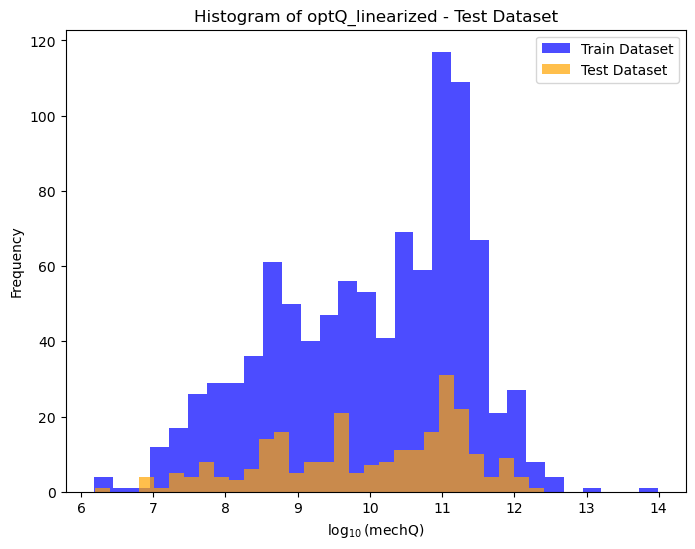

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((paramsMat_transposed, mechQ_linearized))


# Shuffle and split the dataset
train_size = int(0.8 * num_examples)
shuffled_data = dataset.shuffle(buffer_size=num_examples)
train_dataset = shuffled_data.take(train_size)
test_dataset = shuffled_data.skip(train_size)


## let's actually look at our data breakup
show_train_test_dist(train_dataset, test_dataset)
plt.xlabel(r"$\log_{10}(\text{mechQ})$")

# let's 
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [10]:
# load and summarize the base model
base_model_path = r"Z:\lwoodard\Courses\Deep Learning\BDTNet\optcial_Q_Net\conv_model_20241201-205200.keras"

base_model = tf.keras.models.load_model(base_model_path)
base_model.summary()

# chop off the head of the base model and summarize it
truncated_model = tf.keras.Model(inputs = base_model.layers[1].input, outputs = base_model.layers[-3].output) #truncates the functional model from layer 7 to final layer  
truncated_model.summary()

# freeze the params
truncated_model.trainable = False

# add a new head,
dense_layer = tf.keras.layers.Dense(16, activation = "sigmoid")
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=paramsShape)
x = truncated_model(inputs)
x = dense_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

#compile the new model
lr = 1e-4
optimizer = keras.optimizers.Adam(learning_rate = lr)
model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics =['mse'])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 11, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 18, 16)          │           4,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 11, 18, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 6, 9, 24)            │           9,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_11 (ReLU)                      │ (None, 6, 9, 24)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 5, 24)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 360)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 16)                  │           5,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,701 (237.12 KB)

 Trainable params: 20,233 (79.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,468 (158.08 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 11, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 18, 16)          │           4,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 11, 18, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 6, 9, 24)            │           9,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_11 (ReLU)                      │ (None, 6, 9, 24)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 5, 24)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 360)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,440 (56.41 KB)

 Trainable params: 14,440 (56.41 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 11, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 360)                 │          14,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           5,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,233 (79.04 KB)

 Trainable params: 5,793 (22.63 KB)

 Non-trainable params: 14,440 (56.41 KB)

In [11]:
# fit the model
history = model.fit(train_dataset, epochs=400, validation_data=test_dataset)
performance = model.evaluate(test_dataset)


# save the model weights for transfer learning or just bringing the model back to life later
model_name = "conv_model_{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))

weights_path = model_name + ".weights.h5"
model.save_weights(weights_path)

model_path = model_name+".keras"
model.save(model_path)

Epoch 1/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 114.6975 - mse: 114.6975 - val_loss: 111.2317 - val_mse: 111.2317
Epoch 2/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109.8155 - mse: 109.8155 - val_loss: 105.2240 - val_mse: 105.2240
Epoch 3/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105.5003 - mse: 105.5003 - val_loss: 101.5929 - val_mse: 101.5929
Epoch 4/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100.0548 - mse: 100.0548 - val_loss: 97.2173 - val_mse: 97.2173
Epoch 5/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.9204 - mse: 95.9204 - val_loss: 94.5310 - val_mse: 94.5310
Epoch 6/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92.8739 - mse: 92.8739 - val_loss: 89.9672 - val_mse: 89.9672
Epoch 7/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90.9151 - mse: 90.9151 - val_loss: 87.9628 - val_mse: 87.9628
Epoch 8/400
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87.8146 - mse: 87.8146 - val_loss: 82.5613 - val_mse: 82.5613
Epoch 9/400
31/31 

Index(['loss', 'mse', 'val_loss', 'val_mse'], dtype='object')


C:\Users\Linus\AppData\Local\Temp\ipykernel_37364\2160677342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\Linus\AppData\Local\Temp\ipykernel_37364\2160677342.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)


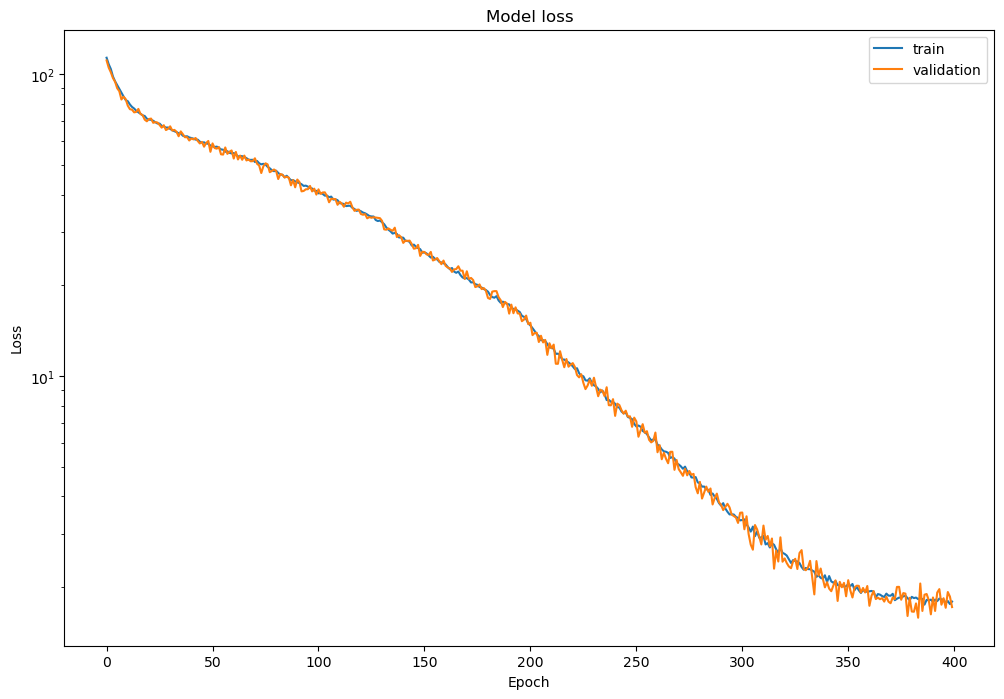

In [12]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_mse= df_loss_acc[['mse','val_mse']]
df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
plt.yscale('log')
fname = model_name  + "_training_hist.png"  #"training_hist_{}.png".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
plt.savefig(fname)

In [13]:
conv_model = tf.keras.models.load_model("{}.keras".format(model_name))
predictions = []
labels = []
example_numbers = np.arange(32)
for batch_number in [1,2,3, 4, 5]:
    predicted, true = show_predicted_Qs(example_numbers, batch_number, test_dataset, conv_model)
    predictions.append(predicted)
    labels.append(true)

predicted Q = 8229398254.621618
true Q = 9627924860.860104

predicted Q = 8230681400.579394
true Q = 143036679161.49695

predicted Q = 8228783861.195428
true Q = 423776013498.2629

predicted Q = 8232055130.630692
true Q = 13990953188.750744

predicted Q = 8232832474.191543
true Q = 674614262.9174551

predicted Q = 8239289068.69078
true Q = 5924929608.118075

predicted Q = 8242709315.48828
true Q = 19201559582.235207

predicted Q = 8237045868.288828
true Q = 2352180473.3732753

predicted Q = 8230084983.913255
true Q = 232458121850.82196

predicted Q = 8244048846.480029
true Q = 1938138152.5450242

predicted Q = 8230645252.88446
true Q = 199889017696.4602

predicted Q = 8231151335.0604925
true Q = 134426185397.36555

predicted Q = 8246746670.709756
true Q = 1306860134.5101597

predicted Q = 8231079035.70165
true Q = 231546013744.056

predicted Q = 8240989966.385263
true Q = 27058593400.464756

predicted Q = 8232434754.362444
true Q = 85133636441.59383

predicted Q = 8234550121.365914
tru

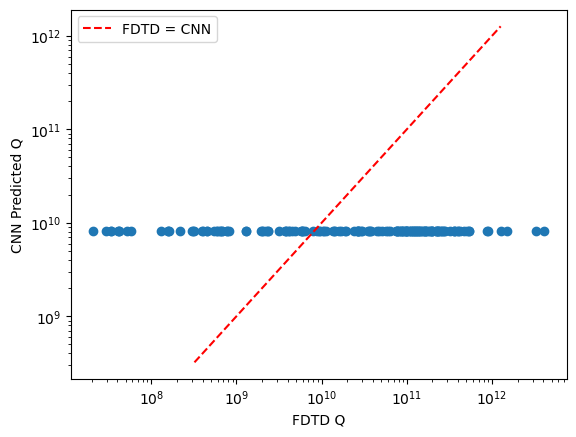

In [14]:
plt.scatter(labels, predictions)
plt.plot([min(labels[0]), max(labels[0])], [min(labels[0]), max(labels[0])], 'r--', label = "FDTD = CNN")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("FDTD Q")
plt.ylabel("CNN Predicted Q")
plt.legend()
fname = "model_prediction_" + model_name + ".png" #"model_prediciton_{}.png".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
plt.savefig(fname, dpi = 400, bbox_inches = 'tight')

It appears that the transfer learning doesn't work so well.  This is liekly because there is actually no correlation between optical and mechanical quality factors. However, I would have guessed that some underying features of the model would have been shared between the two. Try retraining the entire model after loaded, but still loading the weights so that hopefully the training process is faster, or at least the model converges quicker.  Perhaps we still add fresh dense layers so that the same predjudices aren't brought over.

In [20]:
# load and summarize the base model
base_model_path = r"Z:\lwoodard\Courses\Deep Learning\BDTNet\optcial_Q_Net\conv_model_20241201-205200.keras"

base_model = tf.keras.models.load_model(base_model_path)
base_model.summary()

# chop off the head of the base model and summarize it
truncated_model = tf.keras.Model(inputs = base_model.layers[1].input, outputs = base_model.layers[-3].output) #truncates the functional model from layer 7 to final layer  
truncated_model.summary()

# freeze the params
truncated_model.trainable = True

# add a new head,
dense_layer = tf.keras.layers.Dense(16, activation = "sigmoid")
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=paramsShape)
x = truncated_model(inputs)
x = dense_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

#compile the new model
lr = 1e-4
optimizer = keras.optimizers.Adam(learning_rate = lr)
model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics =['mse'])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 11, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 18, 16)          │           4,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 11, 18, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 6, 9, 24)            │           9,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_11 (ReLU)                      │ (None, 6, 9, 24)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 5, 24)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 360)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 16)                  │           5,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,701 (237.12 KB)

 Trainable params: 20,233 (79.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,468 (158.08 KB)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 11, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 18, 16)          │           4,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 11, 18, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 6, 9, 24)            │           9,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_11 (ReLU)                      │ (None, 6, 9, 24)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 5, 24)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 360)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,440 (56.41 KB)

 Trainable params: 14,440 (56.41 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 11, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_6 (Functional)            │ (None, 360)                 │          14,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │           5,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,233 (79.04 KB)

 Trainable params: 20,233 (79.04 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# fit the model
history = model.fit(train_dataset, epochs=700, validation_data=test_dataset)
performance = model.evaluate(test_dataset)


# save the model weights for transfer learning or just bringing the model back to life later
model_name = "conv_model_{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))

weights_path = model_name + ".weights.h5"
model.save_weights(weights_path)

model_path = model_name+".keras"
model.save(model_path)

Epoch 1/700
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5421 - mse: 2.5421 - val_loss: 2.7511 - val_mse: 2.7511
Epoch 2/700
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4878 - mse: 2.4878 - val_loss: 2.1254 - val_mse: 2.1254
Epoch 3/700
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4604 - mse: 2.4604 - val_loss: 2.4494 - val_mse: 2.4494
Epoch 4/700
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3871 - mse: 2.3871 - val_loss: 2.2327 - val_mse: 2.2327
Epoch 5/700
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4287 - mse: 2.4287 - val_loss: 2.3999 - val_mse: 2.3999
Epoch 6/700
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3809 - mse: 2.3809 - val_loss: 2.4689 - val_mse: 2.4689
Epoch 7/700
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3684 - mse: 2.3684 - val_loss: 2.3767 - val_mse: 2.3767
Epoch 8/700
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2038 - mse: 2.2038 - val_loss: 2.4252 - val_mse: 2.4252
Epoch 9/700
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.316

Index(['loss', 'mse', 'val_loss', 'val_mse'], dtype='object')


C:\Users\Linus\AppData\Local\Temp\ipykernel_37364\3661249969.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\Linus\AppData\Local\Temp\ipykernel_37364\3661249969.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)


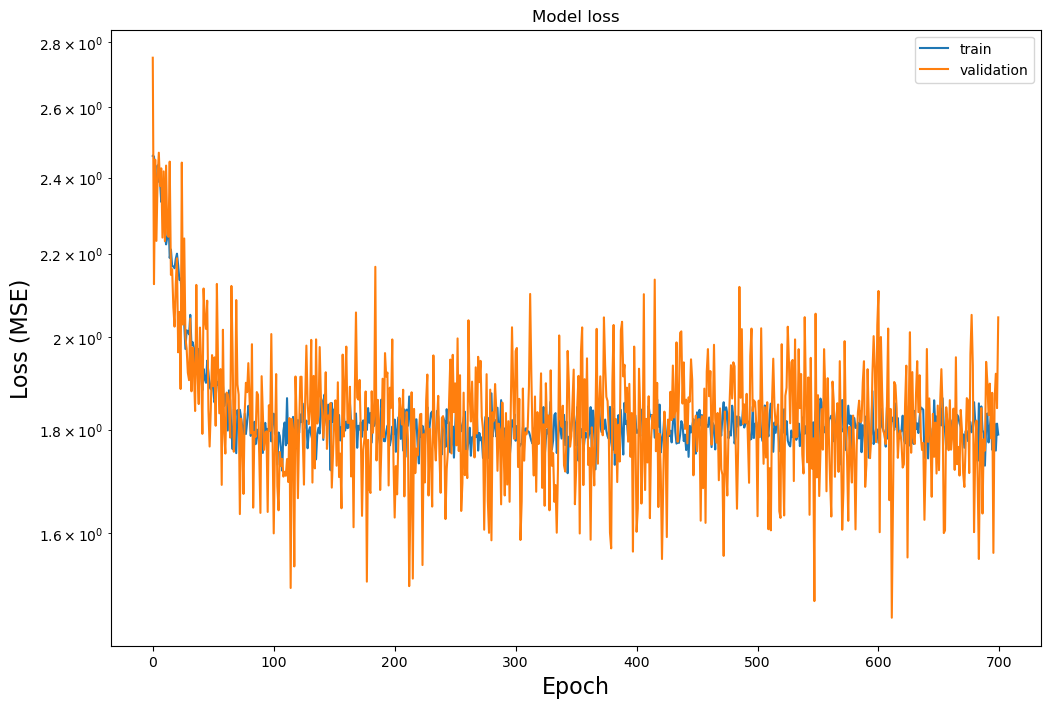

In [30]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_mse= df_loss_acc[['mse','val_mse']]
df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8))
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss (MSE)', fontsize = 16)
plt.yscale('log')
fname = model_name  + "_training_hist.png"  #"training_hist_{}.png".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
plt.savefig(fname)

In [31]:
conv_model = tf.keras.models.load_model("{}.keras".format(model_name))
predictions = []
labels = []
example_numbers = np.arange(32)
for batch_number in [1,2,3, 4, 5]:
    predicted, true = show_predicted_Qs(example_numbers, batch_number, test_dataset, conv_model)
    predictions.append(predicted)
    labels.append(true)

predicted Q = 9908674195.09861
true Q = 421236262015.7482

predicted Q = 9908674195.09861
true Q = 141254003370.6896

predicted Q = 9908674195.09861
true Q = 153710840127.45065

predicted Q = 9908674195.09861
true Q = 418995316499.8147

predicted Q = 9908674195.09861
true Q = 59128215235.9679

predicted Q = 9908674195.09861
true Q = 153951353707.8415

predicted Q = 9908674195.09861
true Q = 261175734945.36185

predicted Q = 9908674195.09861
true Q = 35205581217.42992

predicted Q = 9908674195.09861
true Q = 292043231114.08984

predicted Q = 9908674195.09861
true Q = 60230830369.085

predicted Q = 9908674195.09861
true Q = 4042430090.520423

predicted Q = 9908674195.09861
true Q = 140000275379.06104

predicted Q = 9908674195.09861
true Q = 105645044401.29903

predicted Q = 9908674195.09861
true Q = 56861289.31007873

predicted Q = 9908674195.09861
true Q = 126062890148.46991

predicted Q = 9908674195.09861
true Q = 18979334745.488186

predicted Q = 9908674195.09861
true Q = 272177228034

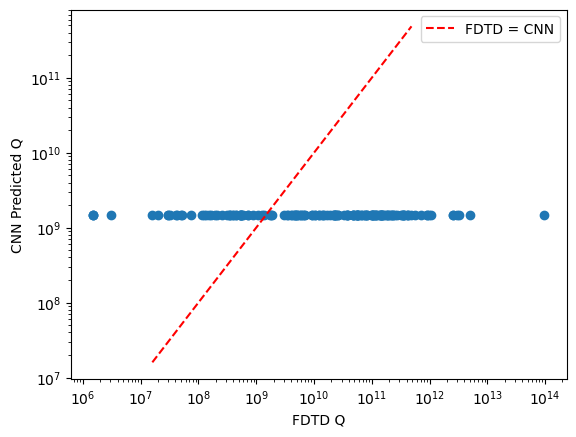

In [24]:
plt.scatter(labels, predictions)
plt.plot([min(labels[0]), max(labels[0])], [min(labels[0]), max(labels[0])], 'r--', label = "FDTD = CNN")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("FDTD Q")
plt.ylabel("CNN Predicted Q")
plt.legend()
fname = "model_prediction_" + model_name + ".png" #"model_prediciton_{}.png".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
plt.savefig(fname, dpi = 400, bbox_inches = 'tight')